<div style="background-color:#000;"><img src="pqn.png"></img></div><div><a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://www.pyquantnews.com/getting-started-with-python-for-quant-finance/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.</div>

## Library installation

Install the libraries we need to download market data and compute downside-risk metrics in the same environment as the notebook.

In [ ]:
!pip install yfinance numpy pandas matplotlib

We use `pandas` and `matplotlib` even though they are not explicitly imported, because `yfinance` returns pandas objects and the `.plot()` call relies on matplotlib behind the scenes.

## Imports and setup

Import `numpy` for fast, vectorized return math and `yfinance` to fetch historical prices for tickers like "SPY" and "AAPL" directly into pandas-friendly objects.

In [ ]:
import numpy as np
import yfinance as yf

Keeping imports minimal makes it easier to see what the workflow depends on, which helps when you later move this from a notebook into a research script or a backtest engine.

## Download prices and compute returns

Pull adjusted market data for "SPY" and "AAPL" over a fixed window so we can compare strategies/assets using the same dates and sampling frequency.

In [ ]:
data = yf.download(["SPY", "AAPL"], start="2020-01-01", end="2024-12-31")
closes = data.Close
spy_returns = closes.SPY.pct_change().dropna()
aapl_returns = closes.AAPL.pct_change().dropna()

Working with daily percentage returns is the standard input format for ratios like Sharpe and Sortino, because it lets us summarize distribution shape rather than price level. Dropping the first NaN avoids quietly propagating missing values into our risk metric, which is a common beginner gotcha when chaining computations.

## Define the Sortino ratio function

Package the Sortino calculation into a reusable function so we can apply it to multiple assets and later to rolling windows without rewriting the logic.

In [ ]:
def sortino_ratio(returns, adjustment_factor=0.0):
    returns_risk_adj = returns - adjustment_factor
    mean_annual_return = returns_risk_adj.mean() * 252
    downside_diff = np.clip(returns_risk_adj, -np.inf, 0.0)
    np.square(downside_diff, out=downside_diff)
    annualized_downside_deviation = np.sqrt(downside_diff.mean()) * np.sqrt(252)

    return mean_annual_return / annualized_downside_deviation

This implementation matches the post’s core idea: we treat upside volatility as neutral and measure “risk” using only negative-return dispersion. The `adjustment_factor` lets us turn this into an excess-return Sortino (for example, subtracting a constant daily cash rate), which is closer to how you’d compare strategies against a hurdle or benchmark in practice.

## Compare levels and rolling behavior

Compute point-in-time Sortino ratios and then visualize how AAPL’s downside-adjusted performance changes over time and relative to SPY.

<Axes: xlabel='Date'>

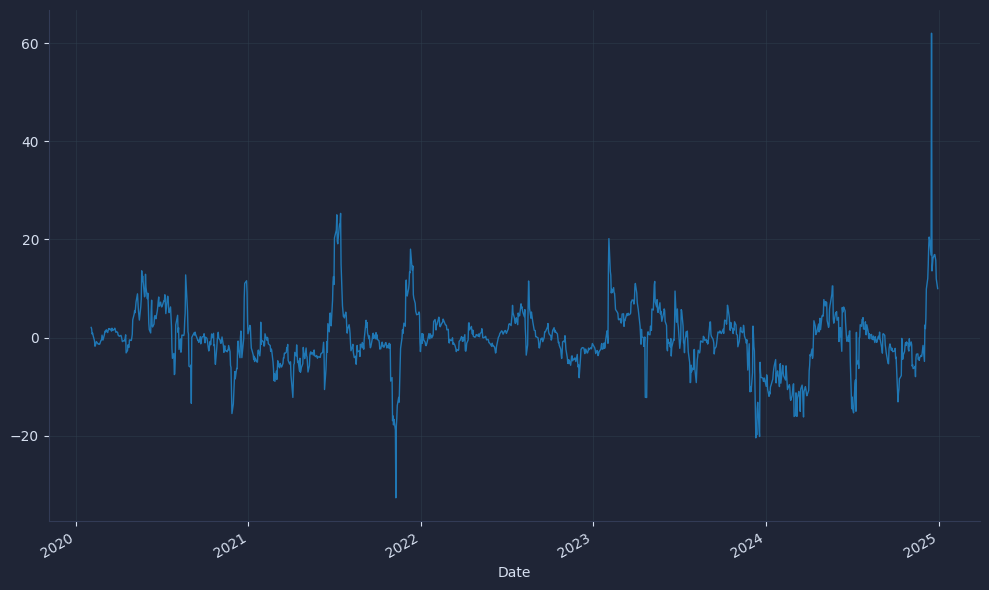

In [40]:
(
    aapl_returns.rolling(21).apply(sortino_ratio) 
    - spy_returns.rolling(21).apply(sortino_ratio)
).plot()

In [ ]:
(
    aapl_returns.rolling(21).apply(sortino_ratio)
    - spy_returns.rolling(21).apply(sortino_ratio)
).hist(bins=50)

A single ratio over the full sample can hide regime shifts, which is exactly how two assets can look “similar on Sharpe” while feeling very different during drawdowns. Rolling Sortino makes the downside-risk story visible through time, and the difference helps us reason about consistency: we’re not just asking “who wins on average,” but “how often does one have cleaner bad-day behavior than the other.”

<a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://www.pyquantnews.com/getting-started-with-python-for-quant-finance/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.